##Importation des libs

In [10]:
import imutils
import numpy as np
import cv2, os
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from tqdm.notebook import tqdm

plt.ion()   # interactive mode

In [11]:
from google.colab import drive # Il faut pouvoir lire les fichiers CSV du Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Modèle prediction casque

In [ ]:
!unzip "drive/MyDrive/Hackathon IA/Bike helmet detection/Faces.zip" -d data

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: data/Faces/train/sans_casque/face13243_524_False.png  
 extracting: data/Faces/train/sans_casque/face13244_524_False.png  
 extracting: data/Faces/train/sans_casque/face13245_524_False.png  
 extracting: data/Faces/train/sans_casque/face13246_524_False.png  
 extracting: data/Faces/train/sans_casque/face13247_524_False.png  
 extracting: data/Faces/train/sans_casque/face13248_524_False.png  
 extracting: data/Faces/train/sans_casque/face13249_524_False.png  
 extracting: data/Faces/train/sans_casque/face13250_524_False.png  
 extracting: data/Faces/train/sans_casque/face13266_525_False.png  
 extracting: data/Faces/train/sans_casque/face13267_525_False.png  
 extracting: data/Faces/train/sans_casque/face13268_525_False.png  
 extracting: data/Faces/train/sans_casque/face13269_525_False.png  
 extracting: data/Faces/train/sans_casque/face13270_525_False.png  
 extracting: data/Faces/train/sans_cas

In [20]:
!ls

3rdparty	DarknetConfig.cmake.in	LICENSE		 src
backup		darknet_images.py	Makefile	 test.jpg
build		darknet.py		net_cam_v3.sh	 vcpkg.json
build.ps1	darknet_video.py	net_cam_v4.sh	 video_yolov3.sh
build.sh	data			obj		 video_yolov4.sh
cfg		image_yolov3.sh		predictions.jpg  yolov3.weights
cmake		image_yolov4.sh		README.md
CMakeLists.txt	include			results
darknet		json_mjpeg_streams.sh	scripts


In [21]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/Faces'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

Device utilisé : cuda:0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


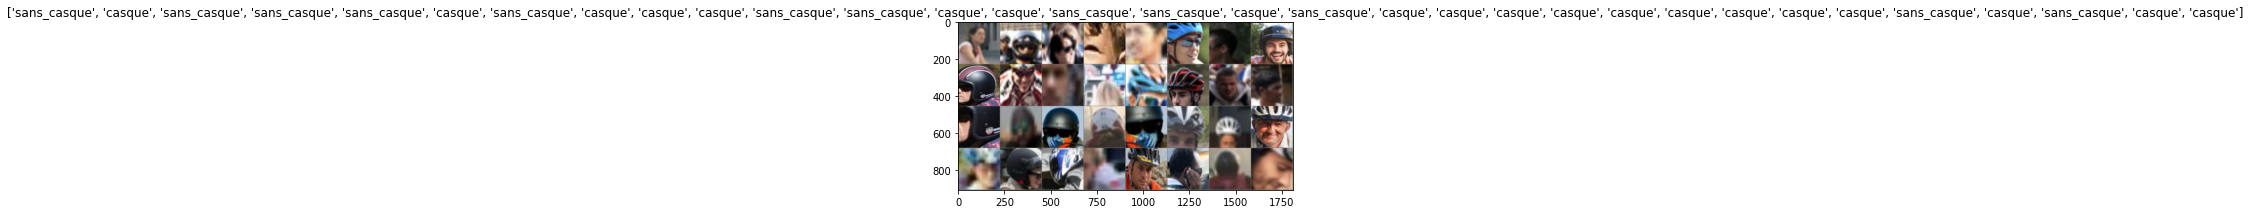

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [26]:
!ls ..

BikesHelmets99.png  data   model_faces_trained.pt  raid_sans.JPG  temps_faces
darknet		    drive  raid_avec.JPG	   sample_data


In [27]:
# Load
PATH = "../drive/MyDrive/Hackathon IA/Bike helmet detection/model_faces_trained.pt"
modelCasques = models.resnet18(pretrained=True)
num_ftrs = modelCasques.fc.in_features
modelCasques.fc = nn.Linear(num_ftrs, 2)
modelCasques = modelCasques.to(device)
modelCasques.load_state_dict(torch.load(PATH))
modelCasques.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


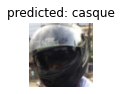

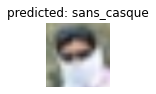

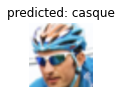

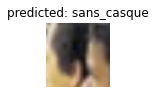

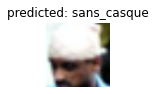

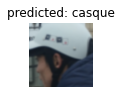

In [28]:
visualize_model(modelCasques)

In [62]:
def predict(model, dl):
  with torch.no_grad():
    for i, inputs in enumerate(dl):
      inputs = inputs.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      return preds.tolist()

# Chargement de YOLO

##Téléchargement de YOLO

In [14]:
!ls
!cd /content
!rm -fr darknet
!git clone https://github.com/AlexeyAB/darknet/
% cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!apt update
!apt-get install libopencv-dev

BikesHelmets99.png  data   model_faces_trained.pt  raid_sans.JPG  temps_faces
darknet		    drive  raid_avec.JPG	   sample_data
Cloning into 'darknet'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14751 (delta 0), reused 1 (delta 0), pack-reused 14748
Receiving objects: 100% (14751/14751), 13.31 MiB | 23.78 MiB/s, done.
Resolving deltas: 100% (10031/10031), done.
/content/darknet
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidi

##Compialtion de YOLO

In [15]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

if ((r>0.9999) && (g<0.0001) && (b>0.9999))
      printf("Personne = %f, %f, %f, %f \n", (float) (x1/((float)(a.w))), (float)(y1/(float)(a.h)), (float)((x2-x1)/(float)(a.w)), (float)((y2-y1)/(float)(a.h)));
    else if((r>0.9999) && (g<0.06251) && (g>0.06249) && (b<0.0001))
      printf("Velo = %f, %f, %f, %f \n", (float) (x1/((float)(a.w))), (float)(y1/(float)(a.h)), (float)((x2-x1)/(float)(a.w)), (float)((y2-y1)/(float)(a.h)));



##Téléchargement des poids

In [16]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-04-11 15:23:07--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  42.9MB/s    in 5.9s    

2021-04-11 15:23:14 (40.1 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



##Méthode pour afficher le résultat

In [17]:
def predictImage(imageDir):
  os.system("cd /content/darknet && ./darknet detect cfg/yolov3.cfg yolov3.weights {}".format(imageDir))
  image = cv2.imread("/content/darknet/predictions.jpg")
  height, width = image.shape[:2]
  #resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)
  #resized_image = cv2.resize(image,(416, 416), interpolation = cv2.INTER_CUBIC)
  resized_image = image

  fig, ax = plt.subplots(figsize=(15,15))
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  ax.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

##Exemple

In [18]:
!wget https://github.com/mozanunal/yoloOnGoogleColab/raw/master/test/test.jpg
!ls

--2021-04-11 15:23:14--  https://github.com/mozanunal/yoloOnGoogleColab/raw/master/test/test.jpg
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mozanunal/yoloOnGoogleColab/master/test/test.jpg [following]
--2021-04-11 15:23:14--  https://raw.githubusercontent.com/mozanunal/yoloOnGoogleColab/master/test/test.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68535 (67K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  66.93K  --.-KB/s    in 0.001s  

2021-04-11 15:23:14 (75.8 MB/s) - ‘test.jpg’ saved [68535/68535]

3rdparty	darknet			include		       results
ba

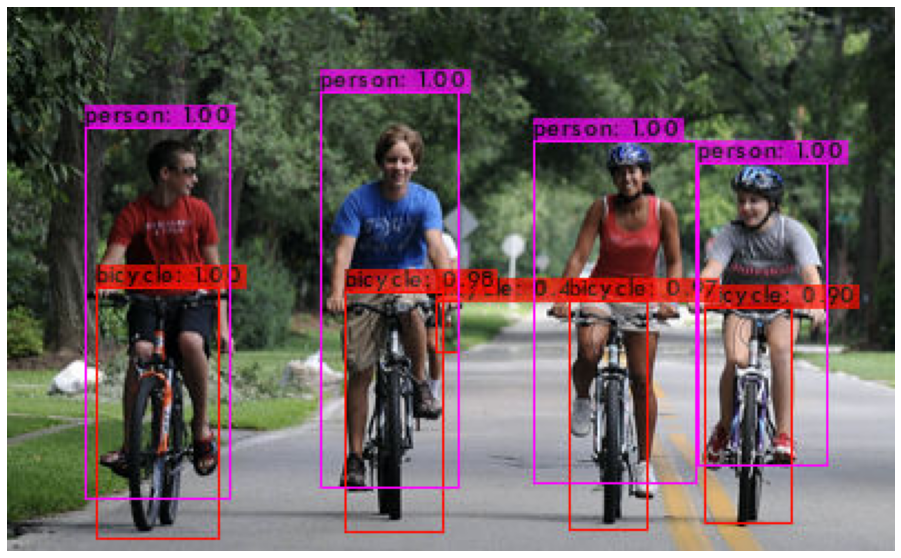

In [19]:
predictImage("../BikesHelmets99.png")

In [29]:
!./darknet detect cfg/yolov3.cfg yolov3.weights ../BikesHelmets0.png >> result9.txt

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 B

##Fonctions géométriques

In [30]:
def intersect(rect1, rect2):
	x1, y1, x2, y2 = rect1[0], rect1[1], rect1[0]+rect1[2], rect1[1]+rect1[3]
	a1, b1, a2, b2 = rect2[0], rect2[1], rect2[0]+rect2[2], rect2[1]+rect2[3]
	return (min(x2,a2) - max(x1,a1) > 0 and min(y2,b2) - max(y1,b1) > 0)
 

def surf_inter(rect1, rect2):
	x1, y1, x2, y2 = rect1[0], rect1[1], rect1[0]+rect1[2], rect1[1]+rect1[3]
	a1, b1, a2, b2 = rect2[0], rect2[1], rect2[0]+rect2[2], rect2[1]+rect2[3]
	dx = max(0, min(x2,a2) - max(x1,a1))
	dy = max(0, min(y2,b2) - max(y1,b1))
	return dx*dy


def surf(rect):
  return rect[2] * rect[3]


def ratio_surface(rect1, rect2):
  return surf_inter(rect1, rect2) / (surf(rect1) + surf(rect2) - surf_inter(rect1, rect2))

##Comptage du nombre de vélos

In [31]:
def get_nb_bicycle(path, threshold=80):
  try:
    os.remove("results.txt")
  except:
    pass
  os.system("./darknet detect cfg/yolov3.cfg yolov3.weights " + path + " >> results.txt")
  file = open("results.txt")
  lignes = file.readlines()
  nbBikes = 0
  for l in lignes:
    if "bicycle: " in l:
      confidence = int(l[l.index("bicycle: ") + len("bicycle: "):l.index("%")])
      if confidence >= threshold:
        nbBikes+=1
  return nbBikes

In [32]:
get_nb_bicycle("../BikesHelmets0.png")

0

In [33]:
def get_objects(path, threshold=0.1, debug=False):
  try:
    os.remove("results.txt")
  except:
    pass
  os.system("./darknet detect cfg/yolov3.cfg yolov3.weights " + path + " >> results.txt")
  file = open("results.txt")
  lignes = file.readlines()
  bikes = []
  people = []
  for l in lignes:
    if "Velo = " in l:
      l = l[l.index("Velo = ") + len("Velo = "):]
      values = l.split(", ")
      rect = [float(v) for v in values]
      if surf(rect) >= 0.5*threshold**2:
        bikes.append([float(v) for v in values])
        if debug: print("Velo trouve", rect)

    elif "Personne = " in l:
      l = l[l.index("Personne = ") + len("Personne = "):]
      values = l.split(", ")
      rect = [float(v) for v in values]
      if surf(rect) >= 0.5*threshold**2:
        people.append(rect)
        if debug: print("Personne trouve", rect)

  return bikes, people

In [34]:
def showObjects(path, threshold=0.1, debug=False):
  bikes, people = get_objects(path, threshold, debug)
  img = cv2.imread(path)
  height, width = img.shape[:2]
  
  fig, ax = plt.subplots(figsize=(15,15))
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  
  for r in bikes:
    x = int(r[0] * float(width))
    y = int(r[1] * float(height))
    w = int(r[2] * float(width))
    h = int(r[3] * float(height))
    rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor="b", facecolor='none')
    ax.add_patch(rect)

  for r in people:
    x = int(r[0] * float(width))
    y = int(r[1] * float(height))
    w = int(r[2] * float(width))
    h = int(r[3] * float(height))
    rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor="r", facecolor='none')
    ax.add_patch(rect)
    
  ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

Velo trouve [0.785, 0.55102, 0.0975, 0.395918]
Velo trouve [0.6325, 0.538776, 0.0875, 0.420408]
Velo trouve [0.38, 0.522449, 0.11, 0.440816]
Personne trouve [0.5925, 0.244898, 0.1825, 0.628571]
Velo trouve [0.1, 0.514286, 0.1375, 0.461224]
Personne trouve [0.3525, 0.155102, 0.155, 0.726531]
Personne trouve [0.0875, 0.220408, 0.1625, 0.681633]
Personne trouve [0.7775, 0.285714, 0.145, 0.555102]


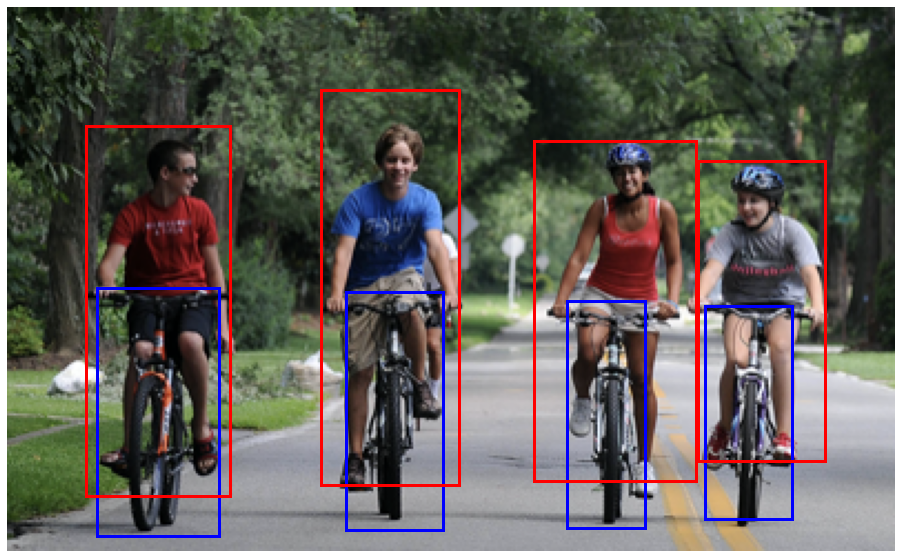

In [35]:
showObjects("../BikesHelmets99.png", debug=True)

In [36]:
def get_people_on_bikes(bikes, people, threshold=0.1, debug=False):
  new_people = []
  for p in people:
    intersection = False
    for b in bikes:
      if ratio_surface(b, p) > threshold:
        intersection = True

    if intersection:
      new_people.append(p)
      if debug: print("Personne validée :", p)

  return new_people

In [37]:
def crop_image(img, rect):
  height, width, channels = img.shape
  return img[int(float(height)*rect[1]):int(float(height)*(rect[1]+rect[3])), int(float(width)*rect[0]):int(float(width)*(rect[0]+rect[2]))]

In [38]:
def get_img_people_on_bikes(path, resize=False, threshold=0.1, debug=False):
  img = cv2.imread(path)
  bikes, people = get_objects(path, threshold=threshold, debug=debug)
  if debug: print("")
  people_on_bikes = get_people_on_bikes(bikes, people, threshold=threshold, debug=debug)
  people_images = []
  bounding_boxes = []

  ratioMax = 1.5
  for rect in people_on_bikes:
    if rect[3] > ratioMax*rect[2]:
      rect[3] = ratioMax*rect[2]
    bounding_boxes.append(rect)
    cropped = crop_image(img, rect)
    if resize: cropped = cv2.resize(cropped, (300, 300))
    people_images.append(cropped)
  return people_images, bounding_boxes

Velo trouve [0.433242, 0.482916, 0.433242, 0.514806]
Personne trouve [0.370572, 0.0, 0.47139, 0.867882]

Personne validée : [0.370572, 0.0, 0.47139, 0.867882]


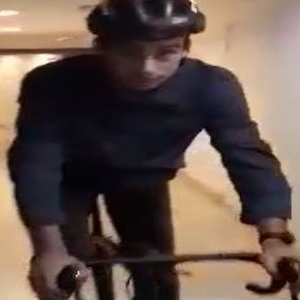

In [39]:
imgs, boxes = get_img_people_on_bikes("../raid_avec.JPG", resize=True, debug=True)
for img in imgs:
  cv2_imshow(img)

In [40]:
def prepare_images(images):
  blobs = []
  for image in images:
    # resize it to have a maximum width of 400 pixels
    image = imutils.resize(image, width=400)
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    blobs.append(blob)
  return blobs

In [46]:
blobs = prepare_images(imgs)
list_detections = []

for blob in blobs:  
  net.setInput(blob)
  detections = net.forward()
  list_detections.append(detections)

96 3 189 101


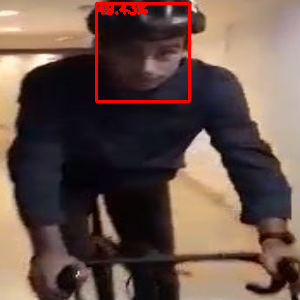

In [47]:
for i in range(len(list_detections)):
  detections = list_detections[i]
  image = imgs[i]
  h, w = image.shape[:2]

  max_confidence = 0
  imax = -1

  for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the prediction
    confidence = detections[0, 0, i, 2]
    if confidence > max_confidence:
      max_confidence = confidence
      imax = i
      
  if imax != -1:
    # filter out weak detections by ensuring the `confidence` is
    # greater than the minimum confidence threshold
    # compute the (x, y)-coordinates of the bounding box for the object
    confidence = detections[0, 0, imax, 2]
    box = detections[0, 0, imax, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    print(startX, startY, endX, endY)
    # draw the bounding box of the face along with the associated probability
    text = "{:.2f}%".format(confidence * 100)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
    cv2.putText(image, text, (startX, y),
    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

  cv2_imshow(image)

In [48]:
def get_faces(path, marge=0.2, threshold=0.1, debug=False):
  imgs, boxes_people = get_img_people_on_bikes(path, True, threshold=threshold, debug=debug) # boxes_people est en [x,y,w,h]
  blobs = prepare_images(imgs)
  list_detections = []
  bounding_boxes = []

  for blob in blobs:  
    net.setInput(blob)
    detections = net.forward()
    list_detections.append(detections)

  if debug: print("")

  for i in range(len(list_detections)):
    detections = list_detections[i]
    image = imgs[i]
    h, w = image.shape[:2]

    max_confidence = 0
    imax = -1

    for j in range(0, detections.shape[2]):
      confidence = detections[0, 0, j, 2]
      if confidence > max_confidence:
        max_confidence = confidence
        imax = j
        
    if imax != -1:
      confidence = detections[0, 0, imax, 2]
      box = detections[0, 0, imax, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      if debug: print("Tete détectée en :", [startX, startY, endX, endY])

      new_box = boxes_people[i]
      new_box[0] += (startX/300.0 - marge) * boxes_people[i][2]
      if new_box[0] < 0 : new_box[0] = 0
      new_box[1] += (startY/300.0 - marge) * boxes_people[i][3]
      if new_box[1] < 0 : new_box[1] = 0
      new_box[2] = ((endX-startX)/300.0 + 2*marge) * new_box[2]
      if new_box[0] + new_box[2] >= 1 : new_box[2] = 1 - new_box[0]
      new_box[3] = ((endY-startY)/300.0 + 2*marge) * new_box[3]
      if new_box[1] + new_box[3] >= 1 : new_box[3] = 1 - new_box[1]
      bounding_boxes.append(new_box)

  return bounding_boxes

In [49]:
def get_images_faces(path, marge=0.2, threshold=0.15, debug=False, output_size=(224,224)):
  boxes = get_faces(path, marge=marge, threshold=threshold, debug=debug)
  img = cv2.imread(path)
  h, w = img.shape[:2]

  images = []
  for i in range(len(boxes)):
    immm = crop_image(img, boxes[i])
    images.append(cv2.resize(immm, output_size))

  return images, boxes

In [50]:
fileName = "../raid_sans.JPG"
boxes = get_faces(fileName, debug=True, threshold=0.1)

Velo trouve [0.445415, 0.524934, 0.131004, 0.44357]
Personne trouve [0.283843, 0.212598, 0.393013, 0.569554]

Personne validée : [0.283843, 0.212598, 0.393013, 0.569554]

Tete détectée en : [73, 7, 172, 76]


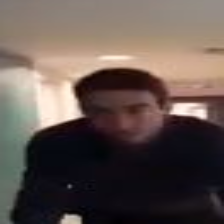

In [51]:
imgs, boxes = get_images_faces(fileName, threshold=0.1)
for img in imgs:
  cv2_imshow(img)

In [52]:
def showImageWithRects(path, rects):
  img = cv2.imread(path)
  height, width = img.shape[:2]
  
  fig, ax = plt.subplots(figsize=(15,15))
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  
  for r in rects:
    x = int(r[0] * float(width))
    y = int(r[1] * float(height))
    w = int(r[2] * float(width))
    h = int(r[3] * float(height))
    rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor="b", facecolor='none')
    ax.add_patch(rect)
    
  ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

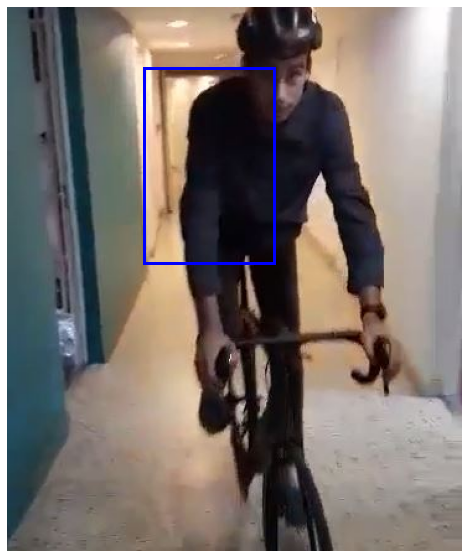

In [70]:
fileName = "../raid_avec.JPG"
showImageWithRects(fileName, boxes)

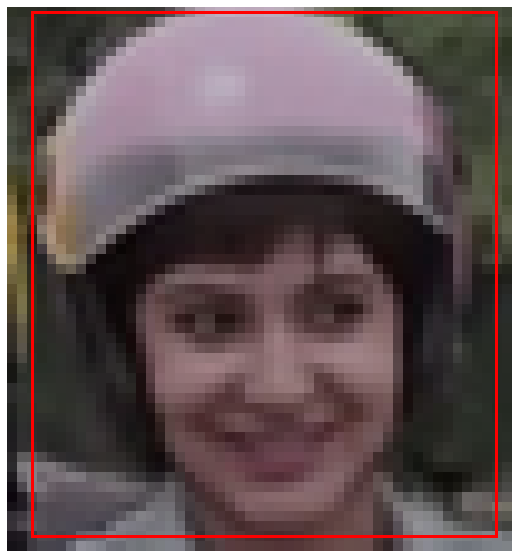

In [68]:
showObjects("../data/Faces/val/casque/face13629_541_True.png", threshold=0.1)

In [55]:
def predict_with_casque(path, debug=False):
  imgs, boxes = get_images_faces(path, debug=False)

  if debug:
    for img in imgs:
      cv2_imshow(img)

  if len(imgs) == 0:
    return False, [], []

  withCasque = True
  missingCasques = []
  nbMissing = 0
  liste_casques = use_casque_mode_multiple(imgs)

  avec_casque = []
  sans_casque = []
  for i in range(len(liste_casques)):
    if liste_casques[i] == 0:
      avec_casque.append(boxes[i])
    else:
      sans_casque.append(boxes[i])

  img = cv2.imread(path)
  return (len(sans_casque) > 0), [crop_image(img, rect) for rect in avec_casque], [crop_image(img, rect) for rect in sans_casque]

In [56]:
from PIL import Image
from matplotlib import cm

##Assemblage

In [ ]:
!mkdir ../temps_faces

In [ ]:
def save_imgs(imgs):
  for i in range(len(imgs)):
    img = imgs[i]
    Image.fromarray(imgs[0].astype('uint8'), 'RGB').save("../temps_faces/" + str(i) + ".jpg")

In [ ]:
save_imgs(imgs)

In [ ]:
!ls ../temps_faces

0.jpg  1.jpg  2.jpg  3.jpg


In [57]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, img_list, augmentations):
    super(MyDataset, self).__init__()
    self.img_list = img_list
    self.augmentations = augmentations

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, idx):
    img = self.img_list[idx]
    return self.augmentations(img)

In [ ]:
image_datasets = MyDataset([Image.fromarray(img.astype('uint8'), 'RGB') for img in imgs], data_transforms["val"])

In [ ]:
print(image_datasets)
dl_prediction = torch.utils.data.DataLoader(image_datasets, batch_size=len(imgs),shuffle=False, num_workers=4)
predictions = predict(modelCasques,dl_prediction)
print(predictions)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0]


In [59]:
def use_casque_mode_multiple(imgs):
  image_datasets = MyDataset([Image.fromarray(img.astype('uint8'), 'RGB') for img in imgs], data_transforms["val"])
  dl_prediction = torch.utils.data.DataLoader(image_datasets, batch_size=len(imgs),shuffle=False, num_workers=4)
  predictions = predict(modelCasques,dl_prediction)
  print("predictions = ", predictions)
  return predictions

# TOUT ASSEMBLE

In [ ]:
!ls ..

BikesHelmets99.png  data   model_faces_trained.pt  raid_sans.JPG  temps_faces
darknet		    drive  raid_avec.JPG	   sample_data


In [67]:
prediction, avec, sans = predict_with_casque("../data/Faces/val/casque/face13629_541_True.png", debug=True)

if prediction:
  print("IL y a quelqu'un qui n'a pas de casque")
else:
  print("Tous les cyclistes ont un casque")

if len(avec) > 0:
  print("\nVoici les cyclistes avec casque")
  for img in avec:
    cv2_imshow(img)

if len(sans) > 0:
  print("\nVoici les cyclistes sans casque")
  for img in sans:
    cv2_imshow(img)

Tous les cyclistes ont un casque


In [71]:
import os
liste_files = []
for dirname, _, filenames in os.walk("../drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/"):
    for filename in filenames:
        liste_files.append(os.path.join(dirname, filename))

print(liste_files)

['../drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/val/sans_casque/image604_False.png', '../drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/val/sans_casque/image507_False.png', '../drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/val/sans_casque/image314_False.png', '../drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/val/sans_casque/image739_False.png', '../drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/val/sans_casque/image747_False.png', '../drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/val/sans_casque/image577_False.png', '../drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/val/sans_casque/image116_False.png', '../drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/val/sans_casque/image707_False.png', '../drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/val/sans_casque/image752_False.png', 

In [ ]:
import os

In [72]:
def checkPerformances():
  total_success = 0
  total_count = 0
  for mode in ['val']:
    for classe in ['casque', 'sans_casque']:
      success = 0
      count = 0
      liste_files = []
      for dirname, _, filenames in os.walk("../drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/" + mode + "/" + classe):
          for filename in filenames:
              liste_files.append(os.path.join(dirname, filename))

      for fileName in liste_files:
        prediction, avec, sans = predict_with_casque(fileName, debug=False)
        if prediction:
          print("IL y a quelqu'un qui n'a pas de casque")
        else:
          print("Tous les cyclistes ont un casque")

        if len(avec) > 0:
          print("\nVoici les cyclistes avec casque")
          for img in avec:
            cv2_imshow(img)

        if len(sans) > 0:
          print("\nVoici les cyclistes sans casque")
          for img in sans:
            cv2_imshow(img)


        if (prediction and classe=="sans_casque") or (not(prediction) and classe=="casque"):
          success+=1
          total_success += 1

        count+=1
        total_count+=1
        print("\n\n")
        print(total_success, "/", total_count)

      print("\n\n\n\n================================================")
      print(mode, "/", classe, ": Success =", success, "/", count, ". Precision =", 100*float(success)/float(count), "%")
      print("================================================\n")

  print("\n\n\n\n=============   RESULTATS FINAUX   =============")
  print(mode, "/", classe, ": Total Success =", total_success, "/", total_count, ". Precision =", 100*float(total_success)/float(total_count), "%")
  print("================================================\n")

In [ ]:
checkPerformances()

Tous les cyclistes ont un casque



1 / 1
Tous les cyclistes ont un casque



2 / 2
Tous les cyclistes ont un casque



3 / 3
Tous les cyclistes ont un casque



4 / 4
Tous les cyclistes ont un casque



5 / 5
Tous les cyclistes ont un casque



6 / 6
Tous les cyclistes ont un casque



7 / 7
Tous les cyclistes ont un casque



8 / 8
Tous les cyclistes ont un casque



9 / 9
Tous les cyclistes ont un casque



10 / 10
Tous les cyclistes ont un casque



11 / 11
Tous les cyclistes ont un casque



12 / 12
Tous les cyclistes ont un casque



13 / 13
Tous les cyclistes ont un casque



14 / 14
Tous les cyclistes ont un casque



15 / 15
Tous les cyclistes ont un casque



16 / 16


#Face detection

In [42]:
image_file = "../BikesHelmets99.png"

400 245


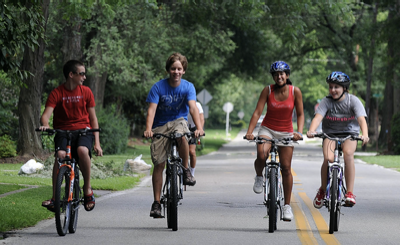

In [43]:
image = cv2.imread(image_file)
# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

##Téléchargement du modèle

Download the pre-trained face detection model, consisting of two files:

- The network definition (deploy.prototxt)
- The learned weights (res10_300x300_ssd_iter_140000.caffemodel) 

In [44]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2021-04-11 15:25:48--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.001s  

Last-modified header missing -- time-stamps turned off.
2021-04-11 15:25:48 (39.3 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2021-04-11 15:25:48--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

##Chargement du modèle

In [45]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


##Conversion de l'image

In [ ]:
# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

##Prédiction

In [ ]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


##Affichage

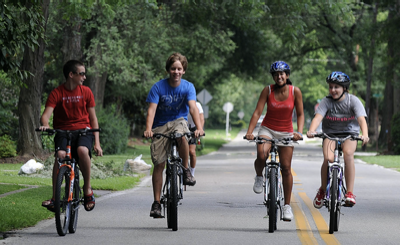

In [ ]:
for i in range(0, detections.shape[2]):

	# extract the confidence (i.e., probability) associated with the prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the `confidence` is
	# greater than the minimum confidence threshold
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# draw the bounding box of the face along with the associated probability
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
  
cv2_imshow(image)

In [ ]:
!pip3 install pyyolo

In [ ]:
# read input image
image = cv2.imread("../BikesHelmets0.png")

Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

# read class names from text file
classes = None
classes = [str(i) for i in range(80)]
"""
with open(args.classes, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
"""
# generate different colors for different classes 
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# read pre-trained model and config file
net = cv2.dnn.readNet("/content/darknet/yolov3.weights", "/content/darknet/cfg/yolov3.cfg")

# create input blob 
blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

# set input blob for the network
net.setInput(blob)

In [ ]:
blob = cv2.dnn.blobFromImage(image, scale, (Width,Height), (0,0,0), True, crop=False)
net.setInput(blob)

In [ ]:
# function to get the output layer names 
# in the architecture
def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

In [ ]:
# run inference through the network
# and gather predictions from output layers
outs = net.forward(get_output_layers(net))

# initialization
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

# for each detetion from each output layer 
# get the confidence, class id, bounding box params
# and ignore weak detections (confidence < 0.5)
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

error: ignored

In [ ]:
!pip install darknet

In [ ]:
import argparse
import os
import glob
import random
import darknet
import time
import cv2
import numpy as np
import darknet


def parser():
    parser = argparse.ArgumentParser(description="YOLO Object Detection")
    parser.add_argument("--input", type=str, default="",
                        help="image source. It can be a single image, a"
                        "txt with paths to them, or a folder. Image valid"
                        " formats are jpg, jpeg or png."
                        "If no input is given, ")
    parser.add_argument("--batch_size", default=1, type=int,
                        help="number of images to be processed at the same time")
    parser.add_argument("--weights", default="yolov4.weights",
                        help="yolo weights path")
    parser.add_argument("--dont_show", action='store_true',
                        help="windown inference display. For headless systems")
    parser.add_argument("--ext_output", action='store_true',
                        help="display bbox coordinates of detected objects")
    parser.add_argument("--save_labels", action='store_true',
                        help="save detections bbox for each image in yolo format")
    parser.add_argument("--config_file", default="./cfg/yolov4.cfg",
                        help="path to config file")
    parser.add_argument("--data_file", default="./cfg/coco.data",
                        help="path to data file")
    parser.add_argument("--thresh", type=float, default=.25,
                        help="remove detections with lower confidence")
    return parser.parse_args()


def check_arguments_errors(args):
    assert 0 < args.thresh < 1, "Threshold should be a float between zero and one (non-inclusive)"
    if not os.path.exists(args.config_file):
        raise(ValueError("Invalid config path {}".format(os.path.abspath(args.config_file))))
    if not os.path.exists(args.weights):
        raise(ValueError("Invalid weight path {}".format(os.path.abspath(args.weights))))
    if not os.path.exists(args.data_file):
        raise(ValueError("Invalid data file path {}".format(os.path.abspath(args.data_file))))
    if args.input and not os.path.exists(args.input):
        raise(ValueError("Invalid image path {}".format(os.path.abspath(args.input))))


def check_batch_shape(images, batch_size):
    """
        Image sizes should be the same width and height
    """
    shapes = [image.shape for image in images]
    if len(set(shapes)) > 1:
        raise ValueError("Images don't have same shape")
    if len(shapes) > batch_size:
        raise ValueError("Batch size higher than number of images")
    return shapes[0]


def load_images(images_path):
    """
    If image path is given, return it directly
    For txt file, read it and return each line as image path
    In other case, it's a folder, return a list with names of each
    jpg, jpeg and png file
    """
    input_path_extension = images_path.split('.')[-1]
    if input_path_extension in ['jpg', 'jpeg', 'png']:
        return [images_path]
    elif input_path_extension == "txt":
        with open(images_path, "r") as f:
            return f.read().splitlines()
    else:
        return glob.glob(
            os.path.join(images_path, "*.jpg")) + \
            glob.glob(os.path.join(images_path, "*.png")) + \
            glob.glob(os.path.join(images_path, "*.jpeg"))


def prepare_batch(images, network, channels=3):
    width = darknet.network_width(network)
    height = darknet.network_height(network)

    darknet_images = []
    for image in images:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image_rgb, (width, height),
                                   interpolation=cv2.INTER_LINEAR)
        custom_image = image_resized.transpose(2, 0, 1)
        darknet_images.append(custom_image)

    batch_array = np.concatenate(darknet_images, axis=0)
    batch_array = np.ascontiguousarray(batch_array.flat, dtype=np.float32)/255.0
    darknet_images = batch_array.ctypes.data_as(darknet.POINTER(darknet.c_float))
    return darknet.IMAGE(width, height, channels, darknet_images)


def image_detection(image_path, network, class_names, class_colors, thresh):
    # Darknet doesn't accept numpy images.
    # Create one with image we reuse for each detect
    width = darknet.network_width(network)
    height = darknet.network_height(network)
    darknet_image = darknet.make_image(width, height, 3)

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (width, height),
                               interpolation=cv2.INTER_LINEAR)

    darknet.copy_image_from_bytes(darknet_image, image_resized.tobytes())
    detections = darknet.detect_image(network, class_names, darknet_image, thresh=thresh)
    darknet.free_image(darknet_image)
    image = darknet.draw_boxes(detections, image_resized, class_colors)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB), detections


def batch_detection(network, images, class_names, class_colors,
                    thresh=0.25, hier_thresh=.5, nms=.45, batch_size=4):
    image_height, image_width, _ = check_batch_shape(images, batch_size)
    darknet_images = prepare_batch(images, network)
    batch_detections = darknet.network_predict_batch(network, darknet_images, batch_size, image_width,
                                                     image_height, thresh, hier_thresh, None, 0, 0)
    batch_predictions = []
    for idx in range(batch_size):
        num = batch_detections[idx].num
        detections = batch_detections[idx].dets
        if nms:
            darknet.do_nms_obj(detections, num, len(class_names), nms)
        predictions = darknet.remove_negatives(detections, class_names, num)
        images[idx] = darknet.draw_boxes(predictions, images[idx], class_colors)
        batch_predictions.append(predictions)
    darknet.free_batch_detections(batch_detections, batch_size)
    return images, batch_predictions


def image_classification(image, network, class_names):
    width = darknet.network_width(network)
    height = darknet.network_height(network)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (width, height),
                                interpolation=cv2.INTER_LINEAR)
    darknet_image = darknet.make_image(width, height, 3)
    darknet.copy_image_from_bytes(darknet_image, image_resized.tobytes())
    detections = darknet.predict_image(network, darknet_image)
    predictions = [(name, detections[idx]) for idx, name in enumerate(class_names)]
    darknet.free_image(darknet_image)
    return sorted(predictions, key=lambda x: -x[1])


def convert2relative(image, bbox):
    """
    YOLO format use relative coordinates for annotation
    """
    x, y, w, h = bbox
    height, width, _ = image.shape
    return x/width, y/height, w/width, h/height


def save_annotations(name, image, detections, class_names):
    """
    Files saved with image_name.txt and relative coordinates
    """
    file_name = name.split(".")[:-1][0] + ".txt"
    with open(file_name, "w") as f:
        for label, confidence, bbox in detections:
            x, y, w, h = convert2relative(image, bbox)
            label = class_names.index(label)
            f.write("{} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}\n".format(label, x, y, w, h, float(confidence)))


def batch_detection_example():
    args = parser()
    check_arguments_errors(args)
    batch_size = 3
    random.seed(3)  # deterministic bbox colors
    network, class_names, class_colors = darknet.load_network(
        args.config_file,
        args.data_file,
        args.weights,
        batch_size=batch_size
    )
    image_names = ['data/horses.jpg', 'data/horses.jpg', 'data/eagle.jpg']
    images = [cv2.imread(image) for image in image_names]
    images, detections,  = batch_detection(network, images, class_names,
                                           class_colors, batch_size=batch_size)
    for name, image in zip(image_names, images):
        cv2.imwrite(name.replace("data/", ""), image)
    print(detections)


def main():
    args = parser()
    check_arguments_errors(args)

    random.seed(3)  # deterministic bbox colors
    network, class_names, class_colors = darknet.load_network(
        args.config_file,
        args.data_file,
        args.weights,
        batch_size=args.batch_size
    )

    images = load_images(args.input)

    index = 0
    while True:
        # loop asking for new image paths if no list is given
        if args.input:
            if index >= len(images):
                break
            image_name = images[index]
        else:
            image_name = input("Enter Image Path: ")
        prev_time = time.time()
        image, detections = image_detection(
            image_name, network, class_names, class_colors, args.thresh
            )
        if args.save_labels:
            save_annotations(image_name, image, detections, class_names)
        darknet.print_detections(detections, args.ext_output)
        fps = int(1/(time.time() - prev_time))
        print("FPS: {}".format(fps))
        if not args.dont_show:
            cv2.imshow('Inference', image)
            if cv2.waitKey() & 0xFF == ord('q'):
                break
        index += 1


if __name__ == "__main__":
    # unconmment next line for an example of batch processing
    # batch_detection_example()
    main()

In [ ]:
!ls

3rdparty		obj
backup			predictions.jpg
build			README.md
build.ps1		res10_300x300_ssd_iter_140000.caffemodel
build.sh		result2.txt
cfg			result3.txt
cmake			result4.txt
CMakeLists.txt		result5.txt
compile.log		result6.txt
darknet			result7.txt
DarknetConfig.cmake.in	result8.txt
darknet_images.py	result9.txt
darknet.py		results
darknet_video.py	results.txt
data			scripts
deploy.prototxt		src
image_yolov3.sh		test.jpg
image_yolov4.sh		test.jpg.1
include			vcpkg.json
json_mjpeg_streams.sh	video_yolov3.sh
LICENSE			video_yolov4.sh
Makefile		yolov3.weights
net_cam_v3.sh		yolov3.weights.1
net_cam_v4.sh


In [ ]:
!gzip ../darknet.tar

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>